#### Connect Viable Models to Web Camera for Real-time Emotion Recognition
This approach first conducts some  analysis on the combined Random forest model (random_forest_model.pk) with the CNN model (model.h5) to leverage both facial landmark detection and the classification power of neural networks. This code was also used for each participant in 'Pilot study: Evaluation of Real-Time Emotion Detection System'.


In [1]:
import os
import numpy as np
import cv2
import dlib
import joblib
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import load_model
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# Code adapted from :
# Load models
rf_model = joblib.load('/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/random_forest_model.pkl')
scaler = joblib.load('/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/scaler.pkl')
cnn_model = load_model('/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/model.h5')

# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier('/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/haar/haarcascade_frontalface_alt2.xml')

# Check if the Haar Cascade file was loaded correctly
if face_cascade.empty():
    raise IOError("Failed to load Haar Cascade file. Please check the file path.")

# Load Dlib's shape predictor for facial landmarks
shape_predictor = dlib.shape_predictor('/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/shape_predictor_68_face_landmarks.dat')

# Define the emotional classes of interest
emotion_map = {
    0: 'angry',
    1: 'happy',
    2: 'sad',
    3: 'neutral'
}

# Initialize video capture
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    for (x, y, w, h) in faces:
        # Get the landmarks
        dlib_rect = dlib.rectangle(x, y, x + w, y + h)
        landmarks = shape_predictor(gray, dlib_rect)

        # Extract features for Random Forest (example features)
        left_eye = np.array([landmarks.part(36).x, landmarks.part(36).y])
        right_eye = np.array([landmarks.part(45).x, landmarks.part(45).y])
        nose_tip = np.array([landmarks.part(30).x, landmarks.part(30).y])
        mouth_left = np.array([landmarks.part(48).x, landmarks.part(48).y])
        mouth_right = np.array([landmarks.part(54).x, landmarks.part(54).y])
        chin = np.array([landmarks.part(8).x, landmarks.part(8).y])

        # Calculate distances (example features)
        eye_distance = np.linalg.norm(left_eye - right_eye)
        nose_to_mouth = np.linalg.norm(nose_tip - (mouth_left + mouth_right) / 2)
        nose_to_left_eye = np.linalg.norm(nose_tip - left_eye)
        nose_to_right_eye = np.linalg.norm(nose_tip - right_eye)
        mouth_width = np.linalg.norm(mouth_left - mouth_right)
        nose_to_chin = np.linalg.norm(nose_tip - chin)
        left_eye_to_chin = np.linalg.norm(left_eye - chin)
        right_eye_to_chin = np.linalg.norm(right_eye - chin)
        mouth_to_chin = np.linalg.norm((mouth_left + mouth_right) / 2 - chin)

        # Prepare the feature vector for Random Forest
        features = np.array([[eye_distance, nose_to_mouth, nose_to_left_eye, nose_to_right_eye, mouth_width, nose_to_chin, left_eye_to_chin, right_eye_to_chin, mouth_to_chin]])
        features_scaled = scaler.transform(features)

        # Predict the emotion with Random Forest
        rf_emotion_label = rf_model.predict(features_scaled)[0]
        print(f"Random Forest predicted label: {rf_emotion_label}")  # Debugging: Print the predicted label
        rf_emotion_text = emotion_map.get(rf_emotion_label, "Unknown")

        # Prepare the image for CNN
        face_img = cv2.resize(frame[y:y+h, x:x+w], (150, 150))
        face_img = face_img / 255.0  # Normalize to [0, 1]
        face_img = np.expand_dims(face_img, axis=0)  # Add batch dimension

        # Predict the emotion with CNN
        cnn_predictions = cnn_model.predict(face_img)
        cnn_emotion_label = np.argmax(cnn_predictions, axis=1)[0]
        print(f"CNN predicted label: {cnn_emotion_label}")  # Debugging: Print the predicted label
        cnn_emotion_text = emotion_map.get(cnn_emotion_label, "Unknown")

        # Combine the predictions (simple voting mechanism)
        if rf_emotion_text == cnn_emotion_text:
            final_emotion_text = rf_emotion_text
        else:
            # If the predictions differ, you can choose one or use a more sophisticated method
            final_emotion_text = cnn_emotion_text  # Example: prioritize CNN prediction

        # Display the emotion on the frame
        cv2.putText(frame, final_emotion_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (36, 255, 12), 2)

    # Display the frame
    cv2.imshow('Emotion Recognition', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture and close windows
cap.release()
cv2.destroyAllWindows()

### Pilot Study on the Emotion Recognition System

In [11]:
import csv

# Created a list of emotion sequence possibilities to randomly choose from for each participant.
emotion_sequences = [
    ("Neutral", "Happy", "Sad", "Angry"),
    ("Angry", "Neutral", "Happy", "Sad"),
    ("Sad", "Happy", "Neutral", "Angry"),
    ("Happy", "Sad", "Angry", "Neutral"),
    ("Neutral", "Angry", "Happy", "Sad"),
    ("Happy", "Neutral", "Sad", "Angry"),
    ("Sad", "Angry", "Neutral", "Happy"),
    ("Angry", "Sad", "Happy", "Neutral"),
    ("Neutral", "Sad", "Happy", "Angry"),
    ("Happy", "Angry", "Neutral", "Sad"),
    ("Sad", "Neutral", "Angry", "Happy"),
    ("Angry", "Happy", "Sad", "Neutral"),
    ("Neutral", "Happy", "Angry", "Sad"),
    ("Sad", "Neutral", "Happy", "Angry"),
    ("Happy", "Sad", "Neutral", "Angry"),
    ("Angry", "Neutral", "Sad", "Happy"),
    ("Neutral", "Sad", "Angry", "Happy"),
    ("Happy", "Neutral", "Angry", "Sad"),
    ("Sad", "Angry", "Happy", "Neutral"),
    ("Angry", "Happy", "Neutral", "Sad"),
    ("Neutral", "Angry", "Sad", "Happy"),
    ("Sad", "Happy", "Angry", "Neutral"),
    ("Happy", "Neutral", "Angry", "Sad"),
    ("Angry", "Sad", "Neutral", "Happy"),
    ("Neutral", "Happy", "Sad", "Angry"),
    ("Happy", "Angry", "Neutral", "Sad"),
    ("Sad", "Neutral", "Happy", "Angry"),
    ("Angry", "Happy", "Sad", "Neutral"),
    ("Neutral", "Sad", "Angry", "Happy"),
    ("Happy", "Sad", "Neutral", "Angry")
]

# Started a new csv file to store the participant data
csv_file = 'Pilot-Study-and-emotion_sequences.csv'

# Add participant data to the CSV file 
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header row
    writer.writerow(["Participant", "Lighting Condition", "Sequence", "Expected Emotions", "Predicted Emotions"])

# add headers for variables 
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(["Participant", "Lighting Condition", "Sequence", "Expected Emotions", "Predicted Emotions"])

# Pilot study: 5 tested participants under different lighting conditions and with different emotional combinations.
# Appended rows for each participant data from study.
    writer.writerow([1, "Bright", 1, "Neutral, Happy, Neutral, Angry", "Neutral, Happy, Neutral, Angry"])  # Sad confused with Neutral
    writer.writerow([1, "Dim", 2, "Angry, Neutral, Happy, Sad", "Angry, Neutral, Happy, Sad"])
    writer.writerow([1, "Natural", 3, "Neutral, Happy, Neutral, Angry", "Neutral, Happy, Neutral, Angry"])  # Sad confused with Neutral
    writer.writerow([2, "Bright", 4, "Happy, Sad, Angry, Neutral", "Happy, Sad, Angry, Neutral"])  # Sad confused with Neutral
    writer.writerow([2, "Dim", 5, "Neutral, Angry, Happy, Neutral", "Neutral, Angry, Happy, Neutral"])    # Sad confused with Neutral
    writer.writerow([2, "Natural", 6, "Happy, Neutral, Neutral, Angry", "Happy, Neutral, Neutral, Angry"])  # Sad confused with Neutral
    writer.writerow([3, "Bright", 7, "Sad, Angry, Neutral, Happy", "Sad, Angry, Neutral, Happy"])  # Sad confused with Neutral
    writer.writerow([3, "Dim", 8, "Angry, Sad, Happy, Neutral", "Angry, Sad, Happy, Neutral"])    # Sad confused with Neutral
    writer.writerow([3, "Natural", 9, "Neutral, Neutral, Happy, Angry", "Neutral, Neutral, Happy, Angry"])
    writer.writerow([4, "Bright", 10, "Happy, Angry, Neutral, Sad", "Happy, Angry, Neutral, Sad"])    # Sad correctly classified
    writer.writerow([4, "Dim", 11, "Neutral, Neutral, Angry, Happy", "Neutral, Neutral, Angry, Happy"])
    writer.writerow([4, "Natural", 12, "Angry, Happy, Sad, Neutral", "Angry, Happy, Sad, Neutral"])
    writer.writerow([5, "Bright", 13, "Neutral, Happy, Angry, Neutral", "Neutral, Happy, Angry, Neutral"])  # Sad confused with Neutral
    writer.writerow([5, "Dim", 14, "Sad, Neutral, Happy, Angry", "Sad, Neutral, Happy, Angry"])
    writer.writerow([5, "Natural", 15, "Happy, Sad, Neutral, Angry", "Happy, Sad, Neutral, Angry"])

### Precision and Accuracy scores:

Model Accuracy: 88.33%
Classification Report:
              precision    recall  f1-score   support

       Angry       1.00      1.00      1.00        15
       Happy       1.00      1.00      1.00        15
     Neutral       0.68      1.00      0.81        15
         Sad       1.00      0.53      0.70        15

    accuracy                           0.88        60
   macro avg       0.92      0.88      0.88        60
weighted avg       0.92      0.88      0.88        60



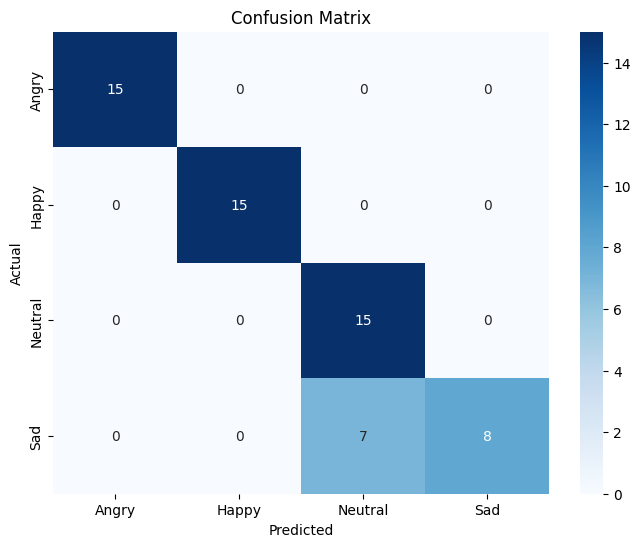

In [12]:
# read csv file 
csv_file = 'Pilot-Study-and-emotion_sequences.csv'
df = pd.read_csv(csv_file)

# Extract the ',Expected Emotions' and 'Predicted Emotions' columns. Code debugged and cleaned with GPT.
expected_emotions = df['Expected Emotions'].str.split(', ').explode().tolist()
predicted_emotions = df['Predicted Emotions'].str.split(', ').explode().tolist()

# Determine unique labels
unique_labels = sorted(set(expected_emotions))

# Calculate accuracy
accuracy = accuracy_score(expected_emotions, predicted_emotions)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Generate classification report
report = classification_report(expected_emotions, predicted_emotions, target_names=unique_labels)
print("Classification Report:")
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(expected_emotions, predicted_emotions, labels=unique_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()